## AggMo — Aggregated Momentum


AggMo — улучшенный метод градиентного спуска с моментом.

В методе градиентного спуска с моментом существует "инерция".

#### Формула обычного градиентного спуска:

$ x_t = x_{t-1} - step*gradient(x_{t-1}) $

$x$ - вектор координат точки.

#### Формула градиентного спуска с моментом:

$ v_t = damping * v_{t-1}-gradient(x_{t-1}) $

$ x_t = x_{t-1} + step*v_t $

step — шаг градиентного спуска.

$ 0 < damping < 1 $ — насколько велика инерция. Чем больше damping, тем сильнее проявляется инерция.

$ v $ — перемещение за предудущий шаг, "скорость".

Градиентный спуск с моментом ускоряет сходимость. Кроме того, не происходит "застревания" на ровных поверхностях, где градиент равен 0.

Однако для высоких значений damipng характерны колебания и нестабильность. 

AggMo решает эту проблему, уменьшая колебания. С использованием AggMo градиентный спуск остается стабильным даже для таких больших значений damping, как 0.999.

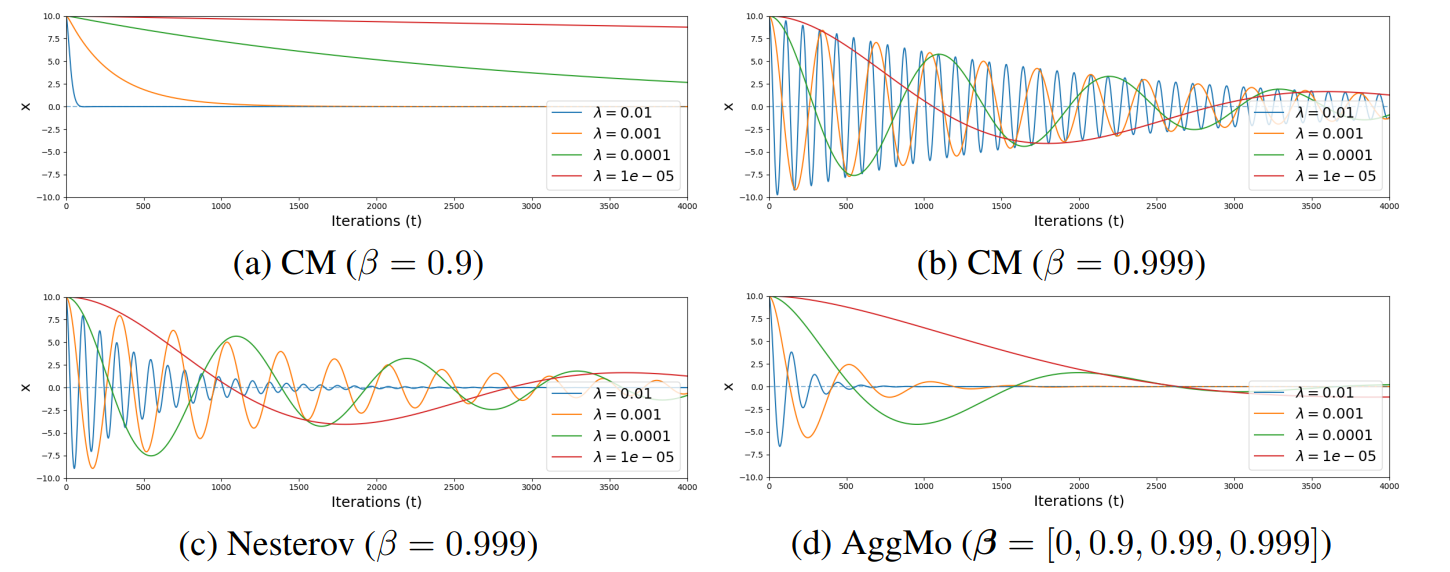

#### Сходимость различных вариантов метода градиентного спуска. Функция — квадратичная.

CM - Classical Momentum, градиентный спуск с моментом.

Nesterov — Nesterov’s Accelerated Gradient, ускоренный градиент Нестерова.

$\beta$ — dumping

$\lambda$ — собственные значения

На всех графиках фиксированный шаг 0.33.

На графиках можно увидеть колебания, о которых шла речь выше.

### Принцип работы



В AggMo не один вектор скорости, а несколько — K. 

Так выглядит вектор скоростей на шаге t при K = 3. Здесь и далее цифры сверху — не степени, а индексы.

$ [v_t^{1}, v_t^{2}, v_t^{3}] $

В начале работы алгоритма все скорости равны 0: $v^i=0$

У каждой скорости есть свой damping. Damping скоростей тоже образуют вектор длины K:

$ [damping_1, damping_2, damping_3] $

Этот вектор мы задаем заранее, до начала работы алгоритма, например:

$ [0, 0.9, 0.99] $

Дальше алгоритм работает так:

$ v_t^i = damping_i * v_{i-1} - gradient(x_{t-t}) $

$ x_t = x_{t-1} + \frac{step}{K}\sum\limits_{i=1}^K v_t^i $

То есть, на каждом шаге алгоритма AggMo мы:
1. Вычисляем скорости так же, как в градиентном спуске с моментом. Только у каждой скорости свой damping.
2. Находим среднее арифметическое этих скоростей.
3. Подставляем среднее арифметическое вместо скорости в формулу следующего x в градиентном спуске с моментом.



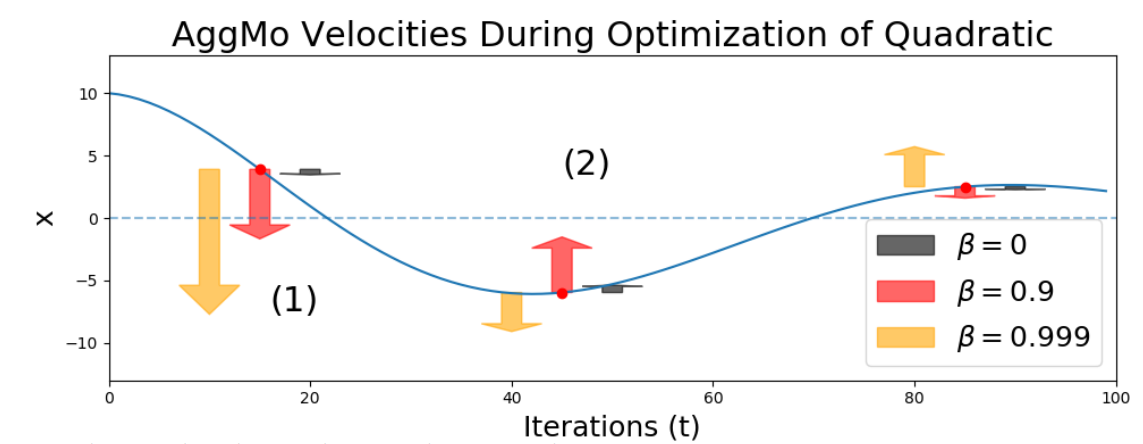

#### Скорости AggMo. Функция — квадратическая.

### Эффективность по времени и по памяти

Вычислительная сложность AggMo лишь незначительно превосходит вычислительную сложность градиентного спуска с моментом.

Дополнительные затраты памяти включают в себя только хранение вектора скоростей и вектора damping, незначительных по объему.

### Реализация

#### Pytorch


**torch-optimizer 0.1.0**

torch-optimizer - набор оптимизаторов для PyTorch

In [ ]:
!pip install torch_optimizer

     |████████████████████████████████| 72 kB 831 kB/s 


In [ ]:
import torch_optimizer as optim

model = ...

optimizer = optim.AggMo(
    model.parameters(),
    lr= 1e-3,
    betas=(0.0, 0.9, 0.99),
    weight_decay=0,
)

optimizer.step() # Выполняет один шаг оптимизации

##### Исходный код

In [ ]:
import torch
from torch.optim.optimizer import Optimizer, required


class AggMo(Optimizer):

    def __init__(self, params, lr=required, betas=[0.0, 0.9, 0.99], weight_decay=0):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super(AggMo, self).__init__(params, defaults)

    @classmethod
    def from_exp_form(cls, params, lr=required, a=0.1, k=3, weight_decay=0):
        betas = [1- a**i for i in range(k)]
        return cls(params, lr, betas, weight_decay)

    def __setstate__(self, state):
        super(AggMo, self).__setstate__(state)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            betas = group['betas']
            total_mom = float(len(betas))

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = {}
                    for beta in betas:
                        param_state['momentum_buffer'][beta] = torch.zeros_like(p.data)
                for beta in betas:
                    buf = param_state['momentum_buffer'][beta]
                    # import pdb; pdb.set_trace()
                    buf.mul_(beta).add_(d_p)
                    p.data.sub_(group['lr'] / total_mom , buf)
        return loss

    def zero_momentum_buffers(self):
        for group in self.param_groups:
            betas = group['betas']
            for p in group['params']:
                param_state = self.state[p]
                param_state['momentum_buffer'] = {}
                for beta in betas:
                    param_state['momentum_buffer'][beta] = torch.zeros_like(p.data)

    def update_hparam(self, name, value):
        for param_group in self.param_groups:
            param_group[name] = value

##### Пример

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
model

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
import torch_optimizer as optim

loss_fn = nn.CrossEntropyLoss()

### AggMo
optimizer = optim.AggMo(
    model.parameters(),
    lr= 1e-3,
    betas=(0.0, 0.9, 0.99),
    weight_decay=0,
)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.309805  [    0/60000]
loss: 2.097386  [ 6400/60000]
loss: 1.243899  [12800/60000]
loss: 0.976227  [19200/60000]
loss: 0.734317  [25600/60000]
loss: 0.649201  [32000/60000]
loss: 0.663289  [38400/60000]
loss: 0.658100  [44800/60000]
loss: 0.655665  [51200/60000]
loss: 0.547394  [57600/60000]
Test Error: 
 Accuracy: 80.3%, Avg loss: 0.558492 

Epoch 2
-------------------------------
loss: 0.441849  [    0/60000]
loss: 0.554822  [ 6400/60000]
loss: 0.352827  [12800/60000]
loss: 0.623813  [19200/60000]
loss: 0.495010  [25600/60000]
loss: 0.505121  [32000/60000]
loss: 0.472155  [38400/60000]
loss: 0.650050  [44800/60000]
loss: 0.594959  [51200/60000]
loss: 0.408778  [57600/60000]
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.480585 

Epoch 3
-------------------------------
loss: 0.319757  [    0/60000]
loss: 0.475031  [ 6400/60000]
loss: 0.303923  [12800/60000]
loss: 0.558333  [19200/60000]
loss: 0.414391  [25600/60000]
loss: 0.461646  [32000/600

## Визуализация и сравнение с обычным градиентным спуском с моментом

Функция:

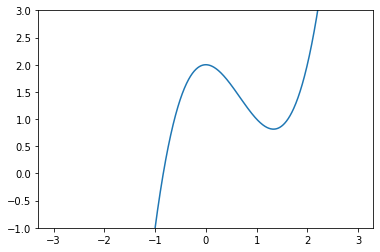

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Наша функция f(x)
func = lambda x: x ** 3 - 2 * x ** 2 + 2
# Производная функции f(x)
d_func = lambda x: 3 * x ** 2 - 4 * x
# Сделаем массив из 1000 элементов от -3 до 3
x = np.linspace(-3, 3, 1000)
# Определим границы по y для графика
plt.ylim([-1, 3])
plt.plot(x, func(x))
plt.show()

Реализация обычного градиентного спуска с моментом.

Реализация представляет собой видоизмененную функцию find_minimum_first_order из Gradient на практике.ipynb

In [ ]:
def find_minimum_simple_momentum(
    damping,
    step=0.05,
    eps=1e-5,
    max_iterations=500,
):
    i = 0
    v_old, v_new = 0, 0
    x_old, x_new = 2, 2
    delta = 100000
    # Будем сохранять обновлённые значения x и y
    x_list, y_list = [x_old], [func(x_old)]
    
    while delta > eps and i < max_iterations:
        first_iter = False
        v_new = damping * v_old - d_func(x_old)
        # Сделаем один шаг gradient descent
        x_new = x_old + step * v_new
        # Обновим x_old
        delta = abs(x_new - x_old)
        x_old = x_new
        v_old = v_new
        # Добавим новые значения для визуализации сходимости
        x_list.append(x_new)
        y_list.append(func(x_new))
        i += 1
    # --------------
    print("Найденный локальный минимум:", x_new)
    if (len(x_list) < max_iterations + 1):
        print("Количество шагов:", len(x_list))
    else:
        print("Градиентный спуск не успел сойтись за", max_iterations, "шагов")
    # Визуализируем сходимость
    plt.figure(figsize=[6, 4])
    plt.ylim([-3, 8])
    plt.scatter(x_list, y_list, c="r", edgecolors='k')
    plt.plot(x_list, y_list, c="r")
    plt.plot(x, func(x), c="b")
    plt.title("Descent trajectory")
    plt.show()

Обычный градиентный спуск с относительно небольшим моментом:

Найденный локальный минимум: 1.3329384964968813
Количество шагов: 146


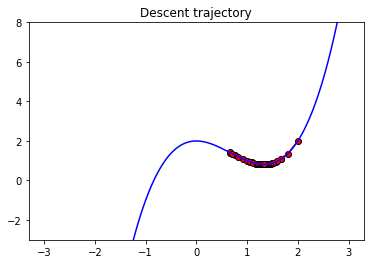

In [ ]:
find_minimum_simple_momentum(damping=0.9)

Обычный градиентный спуск с большим моментом. Даже не успел сойтись за 500 шагов.

Найденный локальный минимум: 1.382677239798767
Градиентный спуск не успел сойтись за 500 шагов


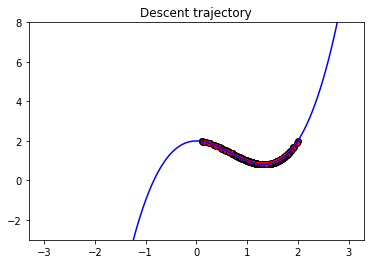

In [ ]:
find_minimum_simple_momentum(damping=0.99)

Реализация AggMo:

In [ ]:
def find_minimum_aggmo(
    dampings: np.ndarray,
    step=0.05,
    eps=1e-5,
    max_iterations=500,
):
    length = len(dampings)
    i = 0
    v_old, v_new = np.zeros(length), np.zeros(length)
    x_old, x_new = 2, 2
    delta = 100000
    # Будем сохранять обновлённые значения x и y
    x_list, y_list = [x_old], [func(x_old)]
    
    while delta > eps and i < max_iterations:
        first_iter = False
        v_new = dampings * v_old - d_func(x_old)
        v_average = np.mean(v_new)
        # Сделаем один шаг gradient descent
        x_new = x_old + step * v_average
        # Обновим x_old
        delta = abs(x_new - x_old)
        x_old = x_new
        v_old = v_new
        # Добавим новые значения для визуализации сходимости
        x_list.append(x_new)
        y_list.append(func(x_new))
        i += 1
    # --------------
    print("Найденный локальный минимум:", x_new)
    if (len(x_list) < max_iterations + 1):
        print("Количество шагов:", len(x_list))
    else:
        print("Градиентный спуск не успел сойтись за", max_iterations, "шагов")
    # Визуализируем сходимость
    plt.figure(figsize=[6, 4])
    plt.ylim([-3, 8])
    plt.scatter(x_list, y_list, c="r", edgecolors='k')
    plt.plot(x_list, y_list, c="r")
    plt.plot(x, func(x), c="b")
    plt.title("Descent trajectory")
    plt.show()

AggMo сходится существенно быстрее. При этом один из моментов в списке — 0.99, при котором обычный градиентный спуск с моментом даже не успел сойтись.

Найденный локальный минимум: 1.3338020161834971
Количество шагов: 119


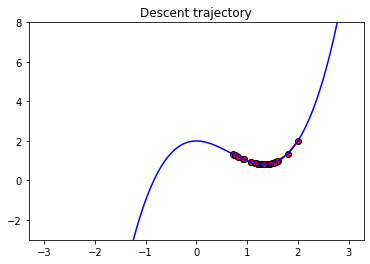

In [ ]:
find_minimum_aggmo(dampings=[0, 0.9, 0.99])

### Список источников ###
https://arxiv.org/pdf/1804.00325v3.pdf — статья, где впервые описан алгоритм

https://pypi.org/project/torch-optimizer/#aggmo — AggMo в Torch Optimizer

https://github.com/AtheMathmo/AggMo — реализация алгоритма
